<a href="https://colab.research.google.com/github/IrynaBarnych/AI12/blob/hw/module4/%D0%94%D0%97_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [1]:
import pandas as pd
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані медичне страхування

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [3]:
df.head()

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [4]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).to(device)
        self.y = torch.FloatTensor(y).to(device)
        self.y = self.y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X = df.drop(columns=['expenses']).to_numpy()
y = df['expenses'].to_numpy()

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [5]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        generator=torch.Generator(device=device))

In [6]:
X_batch, y_batch = next(iter(dataloader))

In [7]:
X_batch.shape

torch.Size([128, 5])

In [8]:
y_batch.shape

torch.Size([128, 1])

In [9]:
X_batch.device

device(type='cpu')

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [10]:
from torch import nn
model = nn.Sequential(
          nn.Linear(5, 10),
          nn.LeakyReLU(),
          nn.Linear(10, 9),
          nn.LeakyReLU(),
          nn.Linear(9, 1),
        )
model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=9, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=9, out_features=1, bias=True)
)

In [11]:
from torchsummary import summary

summary(model, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              60
         LeakyReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 9]              99
         LeakyReLU-4                    [-1, 9]               0
            Linear-5                    [-1, 1]              10
Total params: 169
Trainable params: 169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [12]:
loss_fn = nn.MSELoss()

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [14]:
import numpy as np

num_epochs = 105
losses = []

for epoch in range(num_epochs):
    losses_ = []
    for X_batch, y_batch in dataloader:
        # пряме пошерення
        prediction = model(X_batch)
        loss = loss_fn(prediction, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(np.mean(losses_)**0.5)

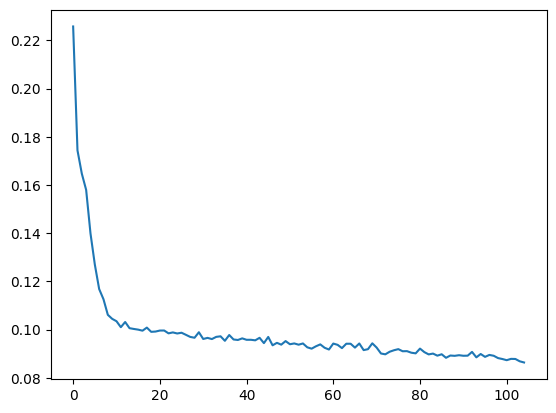

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [16]:
torch.save(model, 'model.pt')

In [17]:
load_model = torch.load('model.pt')

In [18]:
load_model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=9, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=9, out_features=1, bias=True)
)

In [19]:
X_data = torch.FloatTensor(X[[0]])
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]])
torch.Size([1, 5])


In [20]:
load_model(X_data)

tensor([[0.3371]], grad_fn=<AddmmBackward0>)

In [21]:
with torch.no_grad(): # без градієнтів
  print(load_model(X_data))

tensor([[0.3371]])
